# Create Raster Intersection Heatmaps

This notebook creates heatmaps of how much land from new power plant sitings in each scenario intersects with DACs, Important Farmland, and areas in close proximity to Natural Areas 

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

import os
from pathlib import Path

### Collect Data Paths

In [2]:
year = 2050

# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'output_data')

# output figure dir
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures')

# dac analysis files
cg_dac_path = os.path.join(data_dir, f'clean_grid_dac_analysis_{year}.csv')
bau_dac_path = os.path.join(data_dir, f'bau_dac_analysis_{year}.csv')
diff_dac_path = os.path.join(data_dir, f'difference_dac_analysis_{year}.csv')

# farmland dir
cg_farm_path = os.path.join(data_dir, f'clean_grid_farm_analysis_{year}.csv')
bau_farm_path = os.path.join(data_dir, f'bau_farm_analysis_{year}.csv')
diff_farm_path = os.path.join(data_dir, f'difference_farm_analysis_{year}.csv')

# environmental dir
cg_env_path = os.path.join(data_dir, f'clean_grid_env_analysis_{year}.csv')
bau_env_path = os.path.join(data_dir, f'bau_env_analysis_{year}.csv')
diff_env_path = os.path.join(data_dir, f'difference_env_analysis_{year}.csv')

### Collect Data

In [3]:
# dac analysis files
cg_dac_df = pd.read_csv(cg_dac_path)
bau_dac_df = pd.read_csv(bau_dac_path)
diff_dac_df = pd.read_csv(diff_dac_path)

# farmland dir
cg_farm_df = pd.read_csv(cg_farm_path)
bau_farm_df = pd.read_csv(bau_farm_path)
diff_farm_df = pd.read_csv(diff_farm_path)

# environmental dir
cg_env_df = pd.read_csv(cg_env_path)
bau_env_df = pd.read_csv(bau_env_path)
diff_env_df = pd.read_csv(diff_env_path)

### Settings

In [25]:
# dictionary of DAC layers with their simple names
dac_dict = {'gridcerf_usceq_cejst_exclude_all_dacs.tif': 'DACs',
            'gridcerf_usceq_cejst_exclude_energy_dacs.tif': 'Energy DACs',
            'gridcerf_usceq_cejst_exclude_transportation_dacs.tif': 'Transportation DACs',
            'gridcerf_usceq_cejst_exclude_housing_dacs.tif':'Housing DACs',
            'gridcerf_usceq_cejst_exclude_pollution_dacs.tif':'Pollution DACs',
            'gridcerf_usceq_cejst_exclude_health_dacs.tif':'Health DACs',
            'gridcerf_usceq_cejst_exclude_climate_dacs.tif':'Climate DACs',
            'gridcerf_usceq_cejst_exclude_workforce_dacs.tif':'Workforce DACs',
            'gridcerf_usceq_cejst_exclude_water_dacs.tif':'Water DACs'}

# dictionary of important farmland layers with their simple names
farm_dict = {'gridcerf_usda_combined_important_farmland.tif': 'Important Farmland',
            'gridcerf_usda_nrsc_prime_farmland_classification.tif': 'Prime Farmland',
            'gridcerf_usda_nrsc_farmland_of_state_importance.tif': 'Farmland of State Importance',
            'gridcerf_usda_nrsc_farmland_of_local_importance.tif':'Farmland of Local Importance',
            'gridcerf_usda_nrsc_farmland_of_unique_importance.tif':'Farmland of Unique Importance'}

# dictionary of environmental layers with their simple names
env_dict = {'gridcerf_combined_environment_level_1_1buff.tif': 'Within 1 km of Natural Area',
           'gridcerf_combined_environment_level_1_5buff.tif': 'Within 5 km of Natural Area',
           'gridcerf_combined_environment_level_1_10buff.tif': 'Within 10 km of Natural Area',
           }

simple_dict = {
         'Biomass (dry cooling)':'Biomass',
         'Biomass (recirculating cooling)':'Biomass',
         'Biomass CCS (dry cooling)':'Biomass (CCS)',
         'Biomass CCS (recirculating cooling)':'Biomass (CCS)',
         'Biomass IGCC CCS (dry cooling)':'Biomass (CCS)',
         'Biomass IGCC CCS (recirculating cooling)':'Biomass (CCS)',
         'Biomass IGCC CCS (seawater cooling)':'Biomass (CCS)',
         'Coal CCS (dry cooling)':'Coal (CCS)',
         'Coal CCS (recirculating cooling)': 'Coal (CCS)',
         'Natural Gas CC CCS (dry cooling)':'Natural Gas (CCS)',
         'Natural Gas CC CCS (recirculating cooling)':'Natural Gas (CCS)',
         'Natural Gas CC CCS (seawater cooling)':'Natural Gas (CCS)',
         'Offshore Wind':'Offshore Wind',
         'Solar CSP (dry-hybrid cooling)':'Solar CSP',
         'Solar CSP (recirculating cooling)':'Solar CSP',
         'Solar PV':'Solar PV',
         'Wind':'Wind'}

### Functions

In [5]:
def calculate_total_intersections_by_layer(analysis_df, layer_dict, level=None):
    
    """This function takes an intersection analysis output dataframe and groups it to the level 
    indicated. A level value of None summarizes intersections across all parameters, level='tech'
    summarizes intersections by technology type. level='state' summarizes intersections by state.
    level='tech_state' summarizes intersections by both technology and state.
    
    """

    if level is None:
        # group by layer
        df = analysis_df.groupby(['layer'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'total_plants', 'intersection', 'fraction']
        index_values = []

    elif level == 'tech':
        # group by layer & tech
        df = analysis_df.groupby(['layer', 'tech_name'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'tech_name', 'total_plants', 'intersection', 'fraction']
        index_values = ['tech_name']

    elif level == 'state':
        # group by layer & state
        df = analysis_df.groupby(['layer', 'state'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'state', 'total_plants', 'intersection', 'fraction']   
        index_values = ['state']

    elif level == 'state_tech':
        # group by layer & state & tech
        df = analysis_df.groupby(['layer', 'state', 'tech_name'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'state', 'tech_name', 'total_plants', 'intersection', 'fraction']   
        index_values = ['tech_name', 'state']

    if 'total_plants_x' in df.columns:
        output_layer_list.remove('total_plants')
        output_layer_list.remove('fraction')
        
    else:   
        # recalculate intersection fraction
        df['fraction'] = round(df['intersection'] / df['total_plants'], 2)
        
    # simplify naming
    df['layer_name'] = df['layer'].map(layer_dict)

    df[output_layer_list]

    df = pd.pivot_table(df, values='intersection', index=index_values, columns=['layer_name'], aggfunc='sum')

    # sort columns by preferred order
    sort_list = list(layer_dict.values())

    df = df[sort_list]
    
    return df



def plot_heatmap(plot_df, output_file_name, title='', figsize= (12, 12), color_map = ["gold", "seagreen"]): 
    """
    Creates a heatmap of supplied dataframe.
    """
    
    color_cmap = color_map
    cmap1 = LinearSegmentedColormap.from_list('', color_cmap)
    fig, ax = plt.subplots(figsize=figsize)
        
    data = plot_df.to_numpy()
    plt.pcolor(plot_df, cmap=cmap1, edgecolors='black', linewidths=1)
    plt.yticks(np.arange(0.5, len(plot_df.index), 1), plot_df.index)
    plt.xticks(np.arange(0.5, len(plot_df.columns), 1), plot_df.columns)
    for i in range(len(plot_df)):
        for j in range(len(list(plot_df.columns))):
            plt.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                         ha='center', va='center', color='black')
    cbar = plt.colorbar(shrink= .5, label = '$km^2$')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # save figure to folder
    plt.savefig(os.path.join(fig_dir, output_file_name))

    return plt.show()   


## Figure SI-3 - Heatmap of square km in each area of interest by scenario

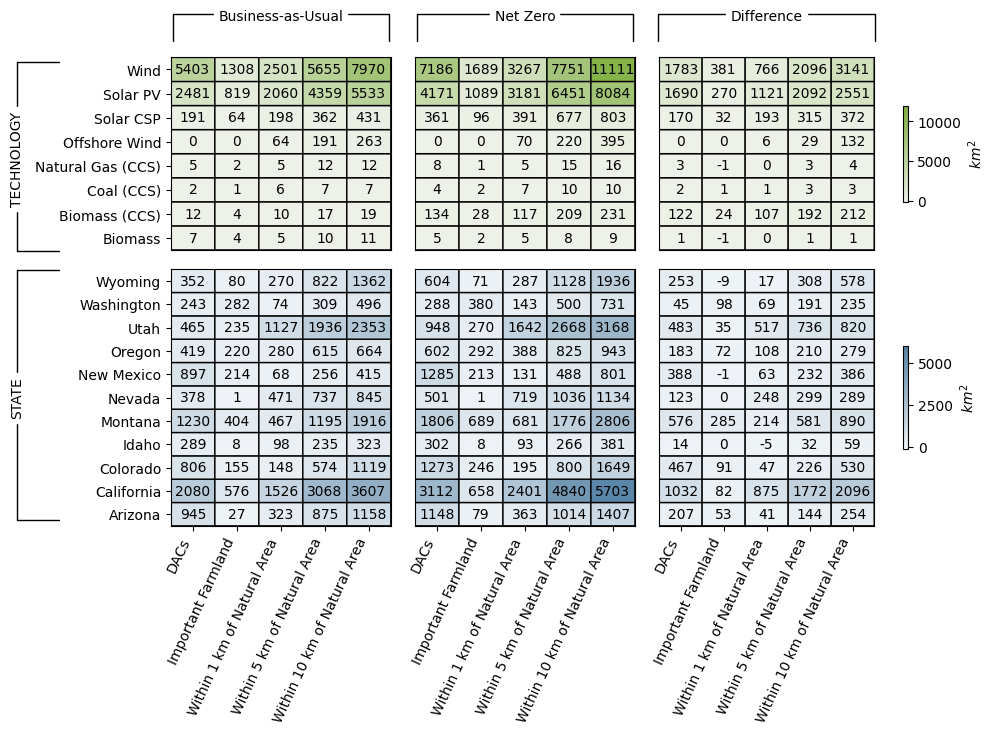

In [19]:
# dictionary of DAC layers with their simple names
short_dac_dict = {'gridcerf_usceq_cejst_exclude_all_dacs.tif': 'DACs'}

# dictionary of important farmland layers with their simple names
short_farm_dict = {'gridcerf_usda_combined_important_farmland.tif': 'Important Farmland'}


# tech_level combined plot
layer_dict = short_dac_dict

# clean grid
analysis_df = cg_dac_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usceq_cejst_exclude_all_dacs.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
cg_dac_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = short_farm_dict
analysis_df = cg_farm_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usda_combined_important_farmland.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
cg_farm_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = env_dict
analysis_df = cg_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
cg_env_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

combined_cg_tech = cg_dac_tech.join(cg_farm_tech)
combined_cg_tech = combined_cg_tech.join(cg_env_tech)


# state level combined plot
layer_dict = short_dac_dict
analysis_df = cg_dac_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usceq_cejst_exclude_all_dacs.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
cg_dac_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = short_farm_dict
analysis_df = cg_farm_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usda_combined_important_farmland.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
cg_farm_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = env_dict
analysis_df = cg_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
cg_env_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

combined_cg_state = cg_dac_state.join(cg_farm_state)
combined_cg_state = combined_cg_state.join(cg_env_state)


## BAU
layer_dict = short_dac_dict
analysis_df = bau_dac_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usceq_cejst_exclude_all_dacs.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
bau_dac_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = short_farm_dict
analysis_df = bau_farm_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usda_combined_important_farmland.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
bau_farm_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = env_dict
analysis_df = bau_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
bau_env_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

combined_bau_tech = bau_dac_tech.join(bau_farm_tech)
combined_bau_tech = combined_bau_tech.join(bau_env_tech)


# state level combined plot
layer_dict = short_dac_dict
analysis_df = bau_dac_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usceq_cejst_exclude_all_dacs.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
bau_dac_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = short_farm_dict
analysis_df = bau_farm_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usda_combined_important_farmland.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
bau_farm_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = env_dict
analysis_df = bau_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
bau_env_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

combined_bau_state = bau_dac_state.join(bau_farm_state)
combined_bau_state = combined_bau_state.join(bau_env_state)


## DIFF
layer_dict = short_dac_dict
analysis_df = diff_dac_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usceq_cejst_exclude_all_dacs.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
diff_dac_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = short_farm_dict
analysis_df = diff_farm_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usda_combined_important_farmland.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
diff_farm_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = env_dict
analysis_df = diff_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
diff_env_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

combined_diff_tech = diff_dac_tech.join(diff_farm_tech)
combined_diff_tech = combined_diff_tech.join(diff_env_tech)


# state level combined plot
layer_dict = short_dac_dict
analysis_df = diff_dac_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usceq_cejst_exclude_all_dacs.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
diff_dac_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = short_farm_dict
analysis_df = diff_farm_df.copy()
analysis_df = analysis_df[analysis_df.layer == 'gridcerf_usda_combined_important_farmland.tif']
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
diff_farm_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = env_dict
analysis_df = diff_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
diff_env_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

combined_diff_state = diff_dac_state.join(diff_farm_state)
combined_diff_state = combined_diff_state.join(diff_env_state)

color_cmap = ["#f0f4f7", "#5381a3"]
g_color_map = ['#eef2e9', '#7dad3d']
blue_cmap = LinearSegmentedColormap.from_list('', color_cmap)
green_cmap = LinearSegmentedColormap.from_list('', g_color_map)

height = 8
width = 10

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=3,
                width_ratios=[.23,.23, .3], 
                wspace=.1,
                hspace=.1,
                height_ratios=[.3 ,.4, .2])


axtech_a =fig.add_subplot(spec[0,0])
axtech_b =fig.add_subplot(spec[0,1])
axtech_c =fig.add_subplot(spec[0,2])

axstate_a =fig.add_subplot(spec[1,0])
axstate_b =fig.add_subplot(spec[1,1])
axstate_c =fig.add_subplot(spec[1,2])

ax3 =fig.add_subplot(spec[2,:])

# TECH INTERACTIONS
# BAU Tech
cmap=green_cmap
vmax = 12000
vmin=-100
# tech DAC
ax = axtech_a
df = combined_bau_tech

data = df.to_numpy()
label_list = np.arange(0.5, len(df.index), 1)
label_val_list = list(df.index)

f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax, vmin=vmin)
ax.set_yticks(label_list)
ax.set_yticklabels(label_val_list)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False,top=False, labelbottom=False)

# Net Zero tech
ax = axtech_b
df = combined_cg_tech
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax, vmin=vmin)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)


# Diff Tech
ax = axtech_c
df = combined_diff_tech
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax, vmin=vmin)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)


cbar = plt.colorbar(f1, shrink= .5, label = '$km^2$', pad=.1)



# STATE INTERACTIONS
cmap=blue_cmap
vmax = 6000

# BAU State
ax = axstate_a

df = combined_bau_state
data = df.to_numpy()
label_list = np.arange(0.5, len(df.index), 1)
label_val_list = list(df.index)

xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)

f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax, vmin=vmin)
ax.set_yticks(label_list)
ax.set_yticklabels(label_val_list)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')

ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top',)

# Net Zero state
ax = axstate_b
df = combined_cg_state
xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)

data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax, vmin=vmin)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top',)


# farm DAC
ax = axstate_c
df = combined_diff_state

xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax, vmin=vmin)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
        
ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top')

cbar = plt.colorbar(f1, shrink= .4, label = '$km^2$', pad=.1)

ax3.set_axis_off()


axtech_a.annotate('TECHNOLOGY', xy=(-.70, .72), xytext=(-.7, .72), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=6.8, lengthA=3, angleA=90',lw=1.0, color='k'))

axstate_a.annotate('STATE', xy=(-.7, .58), xytext=(-0.7, .58), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=9, lengthA=3, angleA=90',lw=1.0, color='k'))

# block text pointers
vertical_adj = 1.25
horizontal_adj = .5
axtech_a.annotate('Business-as-Usual', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=7.8, lengthA=2', lw=1.0, color='k'))
horizontal_adj = .5
axtech_b.annotate('Net Zero', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=7.8, lengthA=2', lw=1.0, color='k'))

axtech_c.annotate('Difference', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=7.8, lengthA=2', lw=1.0, color='k'))

plt.show()

## Additional Figures

#### Detailed Heatmap of Interaction - Net Zero

In [20]:
# tech_level combined plot
layer_dict = dac_dict
analysis_df = cg_dac_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
dac_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = farm_dict
analysis_df = cg_farm_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
farm_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = env_dict
analysis_df = cg_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
env_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')


# state level combined plot
layer_dict = dac_dict
analysis_df = cg_dac_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
dac_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = farm_dict
analysis_df = cg_farm_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
farm_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = env_dict
analysis_df = cg_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
env_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

Text(0.5, 1.29, 'Proximity to\nNatural Areas')

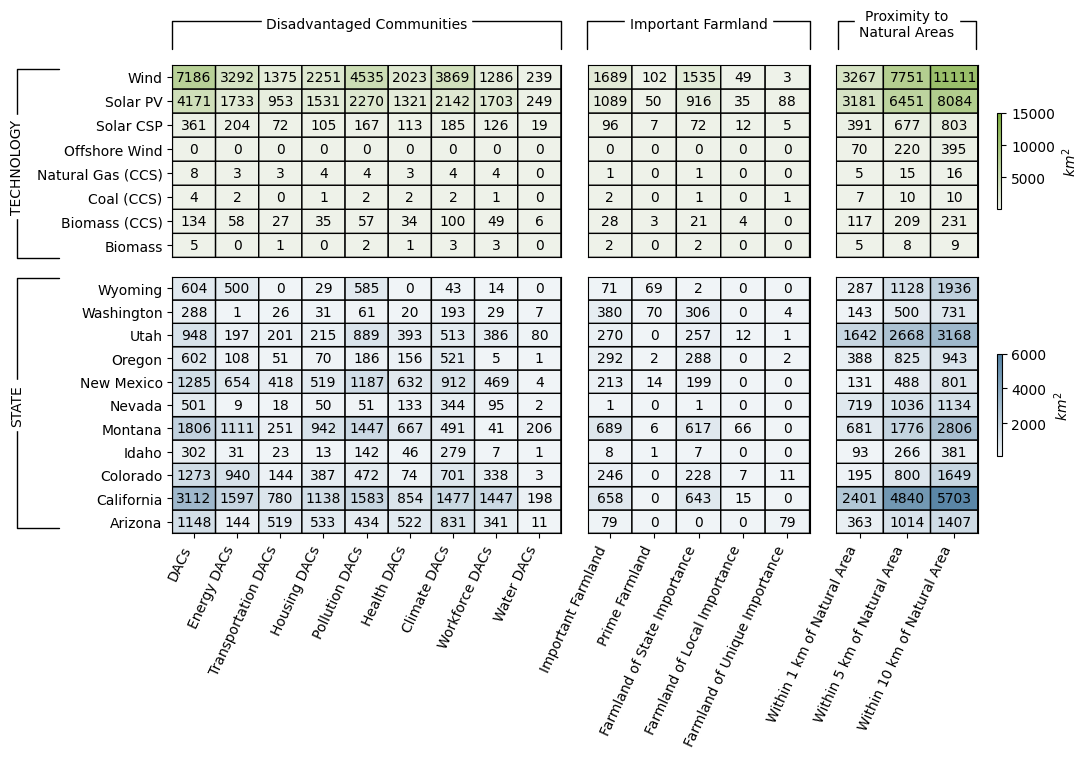

In [21]:
color_cmap = ["#f0f4f7", "#5381a3"]
g_color_map = ['#eef2e9', '#7dad3d']
blue_cmap = LinearSegmentedColormap.from_list('', color_cmap)
green_cmap = LinearSegmentedColormap.from_list('', g_color_map)

height = 8
width = 11

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=3,
                width_ratios=[.35,.2, .17], 
                wspace=.1,
                hspace=.1,
                height_ratios=[.3 ,.4, .2])


axtech_a =fig.add_subplot(spec[0,0])
axtech_b =fig.add_subplot(spec[0,1])
axtech_c =fig.add_subplot(spec[0,2])

axstate_a =fig.add_subplot(spec[1,0])
axstate_b =fig.add_subplot(spec[1,1])
axstate_c =fig.add_subplot(spec[1,2])

ax3 =fig.add_subplot(spec[2,:])


# TECH INTERACTIONS
cmap=green_cmap
vmax = 15000
# tech DAC
ax = axtech_a
df = dac_tech

data = df.to_numpy()
label_list = np.arange(0.5, len(df.index), 1)
label_val_list = list(df.index)

f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
ax.set_yticks(label_list)
ax.set_yticklabels(label_val_list)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False,top=False, labelbottom=False)

# farm DAC
ax = axtech_b
df = farm_tech
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)


# farm DAC
ax = axtech_c
df = env_tech
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)


cbar = plt.colorbar(f1, shrink= .5, label = '$km^2$', pad=.1)


# STATE INTERACTIONS
cmap=blue_cmap
vmax = 6000

# state DAC
ax = axstate_a

df = dac_state
data = df.to_numpy()
label_list = np.arange(0.5, len(df.index), 1)
label_val_list = list(df.index)

xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)

f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
ax.set_yticks(label_list)
ax.set_yticklabels(label_val_list)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')

ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top',)

# farm state
ax = axstate_b
df = farm_state
xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)

data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top',)


# farm DAC
ax = axstate_c
df = env_state

xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
        
ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top')

cbar = plt.colorbar(f1, shrink= .4, label = '$km^2$', pad=.1)

ax3.set_axis_off()

axtech_a.annotate('TECHNOLOGY', xy=(-.40, .72), xytext=(-.4, .72), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=6.8, lengthA=3, angleA=90',lw=1.0, color='k'))

axstate_a.annotate('STATE', xy=(-.4, .58), xytext=(-0.4, .58), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=9, lengthA=3, angleA=90',lw=1.0, color='k'))

# block text pointers
vertical_adj = 1.25
horizontal_adj = .5
axtech_a.annotate('Disadvantaged Communities', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=2', lw=1.0, color='k'))
horizontal_adj = .5
axtech_b.annotate('Important Farmland', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=8, lengthA=2', lw=1.0, color='k'))

axtech_c.annotate('Proximity to\nNatural Areas', xy=(horizontal_adj, vertical_adj+.04), xytext=(horizontal_adj, vertical_adj+.04), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=5, lengthA=2', lw=1.0, color='k'))


#### Detailed Heatmap of Interaction - Business as usual

In [34]:
# tech_level combined plot
layer_dict = dac_dict
analysis_df = bau_dac_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
dac_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = farm_dict
analysis_df = bau_farm_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
farm_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

layer_dict = env_dict
analysis_df = bau_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
env_tech = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')


# state level combined plot
layer_dict = dac_dict
analysis_df = bau_dac_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
dac_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = farm_dict
analysis_df = bau_farm_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
farm_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

layer_dict = env_dict
analysis_df = bau_env_df.copy()
analysis_df['tech_name'] = analysis_df['tech_name'].map(simple_dict)
analysis_df['state'] = analysis_df['state'].str.capitalize()
analysis_df['state'].replace('New_mexico', 'New Mexico', inplace=True)
env_state = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

Text(0.5, 1.29, 'Proximity to\nNatural Areas')

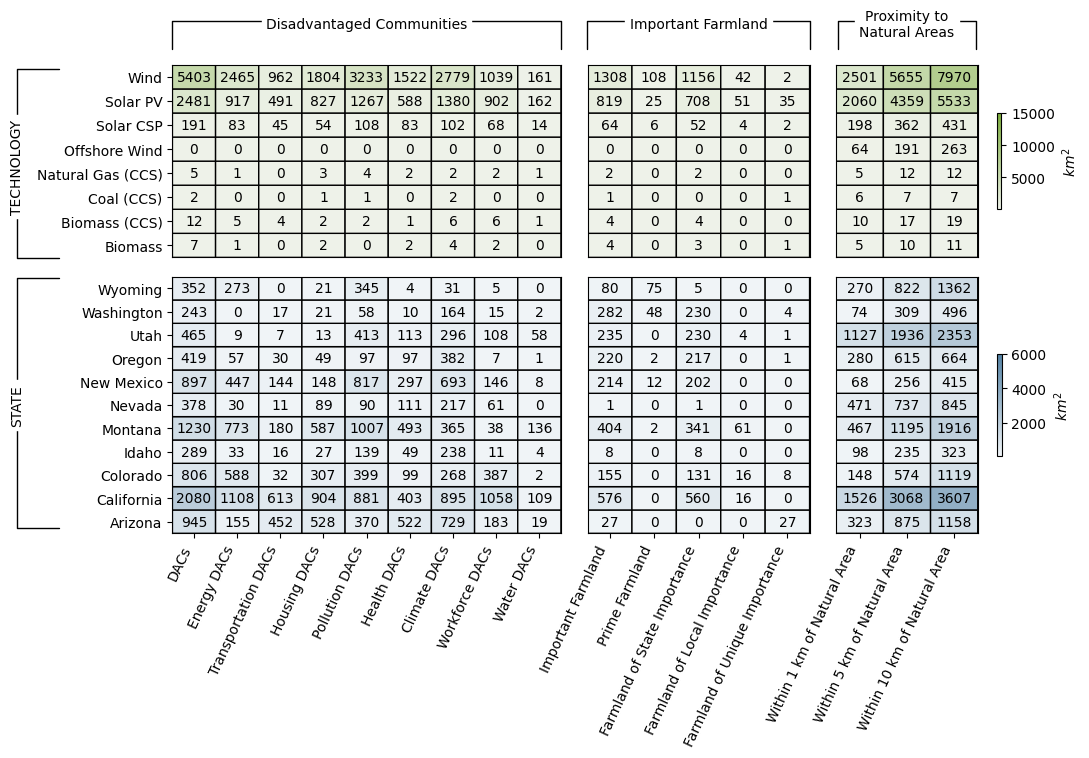

In [35]:
color_cmap = ["#f0f4f7", "#5381a3"]
g_color_map = ['#eef2e9', '#7dad3d']
blue_cmap = LinearSegmentedColormap.from_list('', color_cmap)
green_cmap = LinearSegmentedColormap.from_list('', g_color_map)

height = 8
width = 11

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=3,
                width_ratios=[.35,.2, .17], 
                wspace=.1,
                hspace=.1,
                height_ratios=[.3 ,.4, .2])


axtech_a =fig.add_subplot(spec[0,0])
axtech_b =fig.add_subplot(spec[0,1])
axtech_c =fig.add_subplot(spec[0,2])

axstate_a =fig.add_subplot(spec[1,0])
axstate_b =fig.add_subplot(spec[1,1])
axstate_c =fig.add_subplot(spec[1,2])

ax3 =fig.add_subplot(spec[2,:])


# TECH INTERACTIONS
cmap=green_cmap
vmax = 15000
# tech DAC
ax = axtech_a
df = dac_tech

data = df.to_numpy()
label_list = np.arange(0.5, len(df.index), 1)
label_val_list = list(df.index)

f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
ax.set_yticks(label_list)
ax.set_yticklabels(label_val_list)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False,top=False, labelbottom=False)

# farm DAC
ax = axtech_b
df = farm_tech
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)


# farm DAC
ax = axtech_c
df = env_tech
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)


cbar = plt.colorbar(f1, shrink= .5, label = '$km^2$', pad=.1)


# STATE INTERACTIONS
cmap=blue_cmap
vmax = 6000

# state DAC
ax = axstate_a

df = dac_state
data = df.to_numpy()
label_list = np.arange(0.5, len(df.index), 1)
label_val_list = list(df.index)

xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)

f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
ax.set_yticks(label_list)
ax.set_yticklabels(label_val_list)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')

ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top',)

# farm state
ax = axstate_b
df = farm_state
xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)

data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top',)


# farm DAC
ax = axstate_c
df = env_state

xtick_list = np.arange(0.5, len(df.columns), 1)
xlabel_val_list = np.array(df.columns)
data = df.to_numpy()
f1 = ax.pcolor(df, cmap=cmap, edgecolors='black', linewidths=1, vmax=vmax)
for i in range(len(df)):
    for j in range(len(list(df.columns))):
        t = ax.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                     ha='center', va='center', color='black')
        
ax.tick_params(axis='x',which='both', bottom=True,top=False, labelbottom=True)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xticks(xtick_list)
ax.set_xticklabels(xlabel_val_list)
plt.setp(ax.get_xticklabels(), rotation=65, ha='right', va='top')

cbar = plt.colorbar(f1, shrink= .4, label = '$km^2$', pad=.1)

ax3.set_axis_off()

axtech_a.annotate('TECHNOLOGY', xy=(-.40, .72), xytext=(-.4, .72), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=6.8, lengthA=3, angleA=90',lw=1.0, color='k'))

axstate_a.annotate('STATE', xy=(-.4, .58), xytext=(-0.4, .58), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=9, lengthA=3, angleA=90',lw=1.0, color='k'))

# block text pointers
vertical_adj = 1.25
horizontal_adj = .5
axtech_a.annotate('Disadvantaged Communities', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=2', lw=1.0, color='k'))
horizontal_adj = .5
axtech_b.annotate('Important Farmland', xy=(horizontal_adj, vertical_adj), xytext=(horizontal_adj, vertical_adj), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=8, lengthA=2', lw=1.0, color='k'))

axtech_c.annotate('Proximity to\nNatural Areas', xy=(horizontal_adj, vertical_adj+.04), xytext=(horizontal_adj, vertical_adj+.04), xycoords='axes fraction', 
            fontsize=10, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=5, lengthA=2', lw=1.0, color='k'))


________________

_____________